#**DATA PREPROCESSING**

#DATA EXPLORATION

In [1]:
!pip install transformers
!pip install torch
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import pandas as pd

from google.colab import drive
drive.mount('/content/gdrive')
DATASET = '/content/gdrive/My Drive/tweets_sentiment.csv'
tweets_sentiment = pd.read_csv(DATASET)

Mounted at /content/gdrive


In [6]:
DATASET = '/content/gdrive/My Drive/tweets_sentiment.csv'

In [7]:
tweets_sentiment = pd.read_csv(DATASET)

In [8]:
tweets_sentiment

,tweet_idx,text,label
0,136237,So who got HBO so I can slide over to watch ga...,=
1,116589,Happy #GameofThrones day everyone! Today’s th...,+
2,494264,GAME OF THRONES WTF WAS THAT TRASH?!,-
3,294812,My entire timeline is game of thrones,=
4,538405,Some personal news: Game of Thrones ruined my ...,-
...,...,...,...
6595,315692,Good morning!\r\n\r\nHappy Sunday <U+2600><U+F...,+
6596,299813,Wow I just seen the Avengers movie and now I<U...,+
6597,99914,Chill night binge watching game of thrones🙌🏾,+
6598,683577,"Game of Thrones, thank you for 67 episodes of ...",+


In [9]:
tweets_sentiment['label'].value_counts()

,count
label,
=,4418
-,1096
+,1086


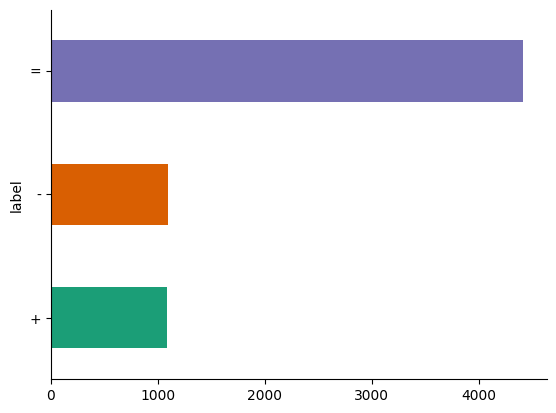

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns
tweets_sentiment.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [11]:
column_name = 'text'
tweets_sentiment['tweet_length'] = tweets_sentiment[column_name].apply(len)

min_length = tweets_sentiment['tweet_length'].min()
print("Length of the shortest tweet:", min_length)

max_length = tweets_sentiment['tweet_length'].max()
print("Length of the longest tweet:", max_length)

Length of the shortest tweet: 15
Length of the longest tweet: 835


#DATA CLEANING

In [12]:
null_values_all = tweets_sentiment.isnull()

print("Rows with null or NaN values in any column:")
print(tweets_sentiment[null_values_all.any(axis=1)])

num_null_values_all = tweets_sentiment.isnull().sum()
print("\nTotal number of null or NaN values in each column:")
print(num_null_values_all)


Rows with null or NaN values in any column:
Empty DataFrame
Columns: [tweet_idx, text, label, tweet_length]
Index: []

Total number of null or NaN values in each column:
tweet_idx       0
text            0
label           0
tweet_length    0
dtype: int64


In [13]:
tweets_longer_than_500 = tweets_sentiment[tweets_sentiment['text'].str.len() > 500]
num_tweets_longer_than_500 = tweets_longer_than_500.shape[0]
print(f"Number of tweets longer than 500 characters: {num_tweets_longer_than_500}")

Number of tweets longer than 500 characters: 3


In [14]:
tweets_sentiment['text'] = tweets_sentiment['text'].astype(str)
tweets_sentiment = tweets_sentiment[tweets_sentiment['text'].str.strip() != '']

def truncate_tweet(text, max_chars=500):
    return text[:max_chars]

tweets_sentiment['text'] = tweets_sentiment['text'].apply(lambda x: truncate_tweet(x))

#HANDLING TEXT DATA: EMBEDDINGS

In [15]:
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import numpy as np

MODEL = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModel.from_pretrained(MODEL)
MAX_TOKENS = 128

def get_bert_embeddings_batch(texts):
    texts = [str(text).strip() for text in texts if isinstance(text, str) and text.strip() != '']
    if not texts:
        raise ValueError("Batch contains no valid text inputs.")

    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=MAX_TOKENS,
        return_tensors='pt'
    )
    inputs = {key: value.to(model.device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    return outputs.last_hidden_state[:, 0, :].squeeze()

batch_size = 128
embeddings_list = []

for i in tqdm(range(0, len(tweets_sentiment['text']), batch_size)):
    batch_tweets = [str(tweet).strip() for tweet in tweets_sentiment['text'][i:i + batch_size] if isinstance(tweet, str) and tweet.strip() != '']
    if not batch_tweets:
        print(f"Skipping empty or invalid batch at index {i}.")
        continue

    try:
        batch_embeddings = get_bert_embeddings_batch(batch_tweets)
        embeddings_list.append(batch_embeddings)
    except ValueError as ve:
        print(f"ValueError in batch at index {i}: {ve}")
    except RuntimeError as re:
        print(f"RuntimeError in batch at index {i}: {re}")

if embeddings_list:
    all_embeddings = torch.cat(embeddings_list, dim=0)
    embeddings_np = all_embeddings.numpy()
    print(f"Shape of embeddings: {embeddings_np.shape}")
else:
    raise ValueError("No embeddings were computed.")

assert isinstance(embeddings_np, np.ndarray), "embeddings_np should be a NumPy array."

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

  0%|          | 0/52 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

100%|██████████| 52/52 [32:58<00:00, 38.05s/it]

Shape of embeddings: (6600, 768)


In [16]:
def get_df_column_names(emb_len):
    col_names = []
    for i in range(emb_len):
        col_names.append(f"emb_{i}")
    return col_names

num_emb = embeddings_np.shape[1]
col_names = get_df_column_names(emb_len=num_emb)

def get_df_with_embeddings(df, col_names):
    tweet_idx_list = df['tweet_idx'].tolist()
    labels = df['label'].tolist() if 'label' in df.columns else []
    df_with_embeddings = pd.DataFrame(data=embeddings_np, index=tweet_idx_list, columns=col_names)
    if labels:
        df_with_embeddings['labels'] = labels
    return df_with_embeddings

df_with_embeddings = get_df_with_embeddings(df=tweets_sentiment, col_names=col_names)
df_with_embeddings

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_759,emb_760,emb_761,emb_762,emb_763,emb_764,emb_765,emb_766,emb_767,labels
136237,-0.298892,0.197250,0.239161,-0.368234,0.103150,0.972686,-0.004252,0.145943,0.925103,-0.532407,...,-0.569035,-1.040392,-0.232249,0.160086,0.004389,-0.063006,-0.229785,0.044018,0.720055,=
116589,0.362165,0.641712,0.159038,-0.451906,1.707857,-0.144846,-0.231416,-0.649462,1.460602,0.736633,...,-1.047751,-1.024938,0.369130,0.222193,0.293519,-0.603422,0.359870,0.841868,1.185751,+
494264,0.473616,0.154292,0.013609,0.258775,-0.201141,-0.521642,0.869496,-0.387166,0.045208,-0.696785,...,-0.150398,1.615929,-1.024879,0.015881,0.320691,1.116588,1.024350,-0.887060,-0.494662,-
294812,0.092434,0.275812,0.270362,-0.126325,0.419427,0.401465,0.027925,0.153056,0.986995,-0.220256,...,-0.688756,-0.122889,-0.342210,0.416423,0.126982,-0.170962,0.392155,-0.099326,0.643245,=
538405,0.574295,0.799780,0.312046,0.118250,0.216499,0.117129,0.905678,-0.659048,0.650367,-0.728732,...,0.007692,1.399317,-0.840383,0.263956,0.043714,0.914955,1.197495,-0.575095,-0.466526,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315692,-0.032747,0.179998,0.083930,-0.016412,1.140184,0.593029,-0.060802,-0.676582,1.380128,0.304840,...,-1.064792,-1.109505,0.464518,0.240058,0.565102,-0.356469,-0.126675,0.844679,1.013289,+
299813,0.140216,0.484914,0.394957,-0.212508,1.468108,-0.164450,0.011351,-0.663912,1.062082,0.321110,...,-0.955027,-0.090951,0.447335,-0.185195,0.573156,-0.156685,-0.543020,0.750214,0.855973,+
99914,-0.158875,1.161447,0.197356,-0.019624,1.585592,0.320970,-0.292825,-0.947163,1.477053,-0.334476,...,-1.381507,0.024100,0.617709,-0.228279,0.432790,-0.852799,-0.908041,0.803223,1.313894,+
683577,0.105481,1.278957,-0.034845,-0.230251,1.477270,-0.620097,-0.219217,-0.660717,1.428921,0.309648,...,-1.004585,0.411573,0.457698,-0.122171,0.381997,-0.436382,0.720798,0.721341,0.851895,+


#TRAIN AND EVALUATE THE MODEL


In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

#No Oversampling and no class-weights

Epoch 1/60
145/145 - 5s - 36ms/step - accuracy: 0.7353 - loss: 5.8278 - val_accuracy: 0.8010 - val_loss: 2.2010 - learning_rate: 0.0010
Epoch 2/60
145/145 - 2s - 16ms/step - accuracy: 0.7690 - loss: 1.5262 - val_accuracy: 0.8040 - val_loss: 1.0291 - learning_rate: 0.0010
Epoch 3/60
145/145 - 3s - 18ms/step - accuracy: 0.7825 - loss: 0.9188 - val_accuracy: 0.8040 - val_loss: 0.7641 - learning_rate: 0.0010
Epoch 4/60
145/145 - 3s - 22ms/step - accuracy: 0.7775 - loss: 0.7663 - val_accuracy: 0.8061 - val_loss: 0.6638 - learning_rate: 0.0010
Epoch 5/60
145/145 - 2s - 15ms/step - accuracy: 0.7771 - loss: 0.6979 - val_accuracy: 0.7798 - val_loss: 0.7061 - learning_rate: 0.0010
Epoch 6/60
145/145 - 2s - 14ms/step - accuracy: 0.7911 - loss: 0.6622 - val_accuracy: 0.8121 - val_loss: 0.6059 - learning_rate: 0.0010
Epoch 7/60
145/145 - 2s - 12ms/step - accuracy: 0.7892 - loss: 0.6554 - val_accuracy: 0.8182 - val_loss: 0.6002 - learning_rate: 0.0010
Epoch 8/60
145/145 - 1s - 7ms/step - accuracy: 0

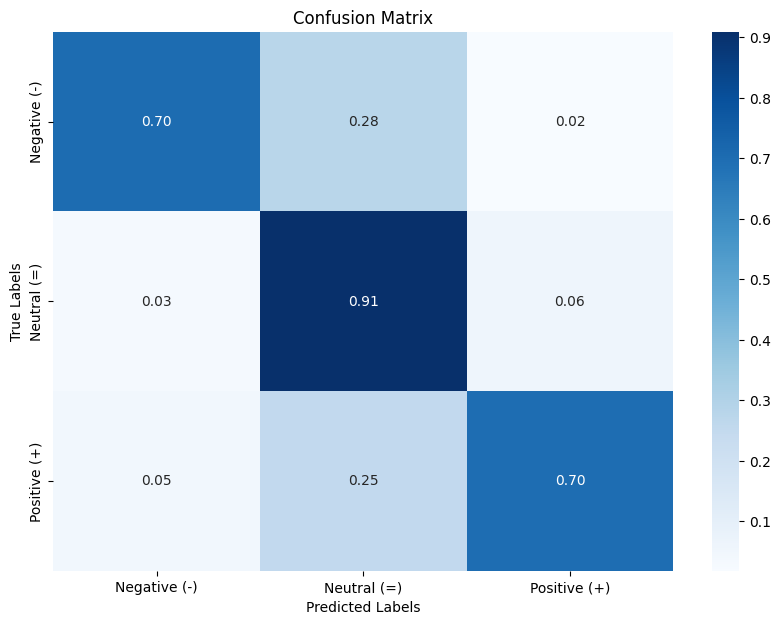

In [24]:
ENCODE = {"-": 0, "=": 1, "+": 2}
DECODE = {0: "-", 1: "=", 2: "+"}

def get_train_test(emb_df):
    X = emb_df[[f'emb_{i}' for i in range(768)]].values
    y = emb_df.labels.apply(lambda lab: ENCODE[lab]).values

    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

def get_model(input_dim):
    model = Sequential([
        Input((input_dim,)),
        Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def get_scores(emb_df):
    X_train, X_val, X_test, y_train, y_val, y_test = get_train_test(emb_df)

    mlp = get_model(input_dim=768)

    early_stopping = EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    )

    lr_reduction = ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
    )

    history = mlp.fit(
        x=X_train,
        y=y_train,
        validation_data=(X_val, y_val),
        epochs=60,
        batch_size=32,
        callbacks=[early_stopping, lr_reduction],
        verbose=2
    )

    y_pred = mlp.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y_test, y_pred_labels)
    print(f"\nTest Accuracy: {accuracy:.4f}")

    report = classification_report(y_test, y_pred_labels, target_names=["Negative (-)", "Neutral (=)", "Positive (+)"])
    print("\nClassification Report:\n", report)

    cm = confusion_matrix(y_test, y_pred_labels, normalize='true')

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=["Negative (-)", "Neutral (=)", "Positive (+)"],
                yticklabels=["Negative (-)", "Neutral (=)", "Positive (+)"])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return history

history = get_scores(df_with_embeddings)

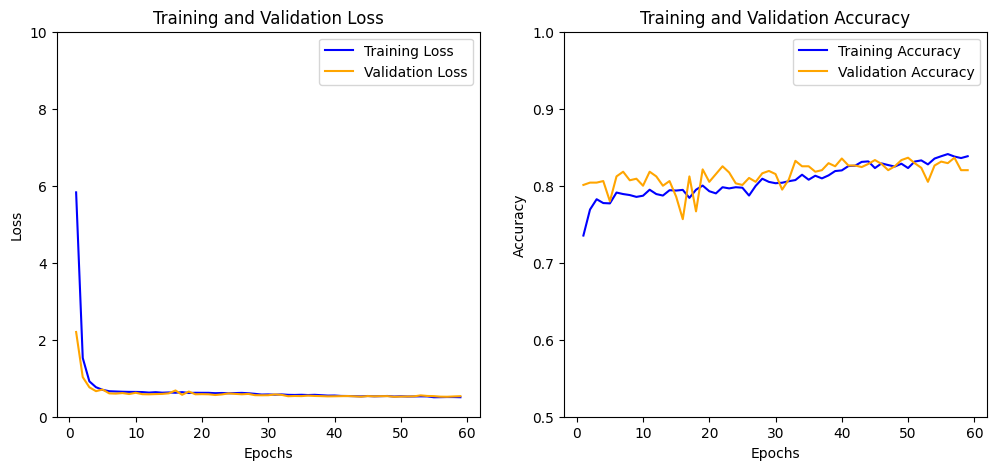

In [25]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss', color='blue')
    plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.ylim(0, 10)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Training Accuracy', color='blue')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.ylim(0.50, 1)
    plt.legend()

    plt.show()

plot_learning_curves(history)

#Class weights

Epoch 1/60
145/145 - 7s - 45ms/step - accuracy: 0.6344 - loss: 6.2106 - val_accuracy: 0.7889 - val_loss: 2.4872 - learning_rate: 0.0010
Epoch 2/60
145/145 - 2s - 11ms/step - accuracy: 0.7026 - loss: 1.8573 - val_accuracy: 0.7081 - val_loss: 1.3563 - learning_rate: 0.0010
Epoch 3/60
145/145 - 2s - 15ms/step - accuracy: 0.7000 - loss: 1.1720 - val_accuracy: 0.7505 - val_loss: 0.9639 - learning_rate: 0.0010
Epoch 4/60
145/145 - 1s - 9ms/step - accuracy: 0.7054 - loss: 0.9516 - val_accuracy: 0.6788 - val_loss: 0.9557 - learning_rate: 0.0010
Epoch 5/60
145/145 - 1s - 9ms/step - accuracy: 0.6968 - loss: 0.8587 - val_accuracy: 0.6889 - val_loss: 0.9092 - learning_rate: 0.0010
Epoch 6/60
145/145 - 2s - 12ms/step - accuracy: 0.7227 - loss: 0.8234 - val_accuracy: 0.6879 - val_loss: 0.9038 - learning_rate: 0.0010
Epoch 7/60
145/145 - 1s - 9ms/step - accuracy: 0.7017 - loss: 0.8154 - val_accuracy: 0.7677 - val_loss: 0.7266 - learning_rate: 0.0010
Epoch 8/60
145/145 - 1s - 8ms/step - accuracy: 0.70

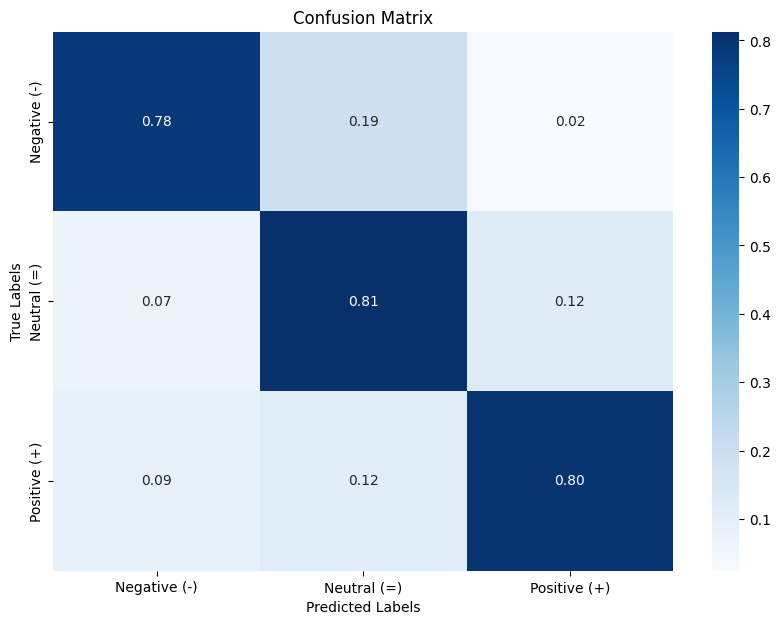

In [26]:
ENCODE = {"-": 0, "=": 1, "+": 2}
DECODE = {0: "-", 1: "=", 2: "+"}

def get_train_test(emb_df):
    X = emb_df[[f'emb_{i}' for i in range(768)]].values
    y = emb_df.labels.apply(lambda lab: ENCODE[lab]).values

    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

def get_model(input_dim):
    model = Sequential([
        Input((input_dim,)),
        Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def get_scores(emb_df):
    X_train, X_val, X_test, y_train, y_val, y_test = get_train_test(emb_df)

    mlp = get_model(input_dim=768)

    class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
    class_weights = dict(enumerate(class_weights))

    early_stopping = EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    )
    lr_reduction = ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
    )

    history = mlp.fit(
        x=X_train,
        y=y_train,
        validation_data=(X_val, y_val),
        epochs=60,
        batch_size=32,
        class_weight=class_weights,
        callbacks=[early_stopping, lr_reduction],
        verbose=2
    )

    y_pred = mlp.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y_test, y_pred_labels)
    print(f"\nTest Accuracy: {accuracy:.4f}")

    report = classification_report(y_test, y_pred_labels, target_names=["Negative (-)", "Neutral (=)", "Positive (+)"])
    print("\nClassification Report:\n", report)

    cm = confusion_matrix(y_test, y_pred_labels, normalize='true')

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=["Negative (-)", "Neutral (=)", "Positive (+)"],
                yticklabels=["Negative (-)", "Neutral (=)", "Positive (+)"])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return history

history = get_scores(df_with_embeddings)

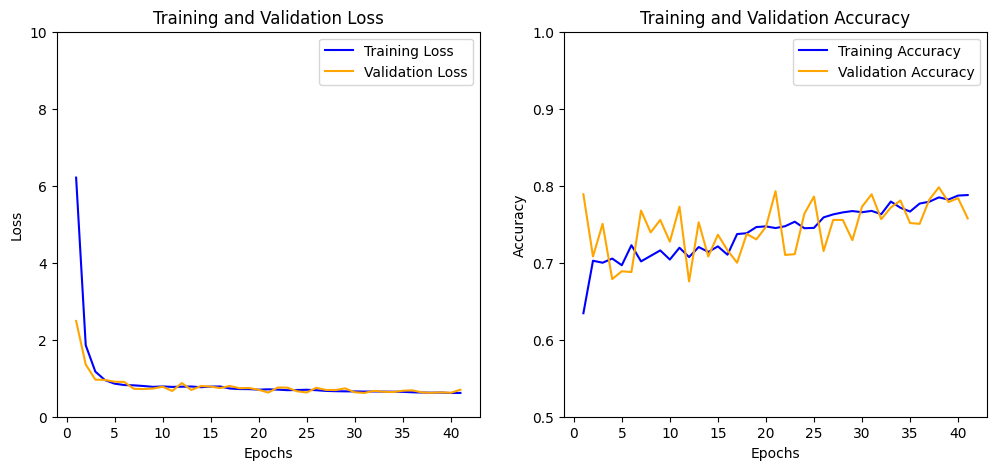

In [27]:
plot_learning_curves(history)

#Oversampling

Epoch 1/60
290/290 - 5s - 18ms/step - accuracy: 0.7240 - loss: 3.9073 - val_accuracy: 0.7586 - val_loss: 1.2449 - learning_rate: 0.0010
Epoch 2/60
290/290 - 4s - 14ms/step - accuracy: 0.7543 - loss: 0.9823 - val_accuracy: 0.6525 - val_loss: 1.0096 - learning_rate: 0.0010
Epoch 3/60
290/290 - 3s - 9ms/step - accuracy: 0.7625 - loss: 0.7770 - val_accuracy: 0.6455 - val_loss: 0.9478 - learning_rate: 0.0010
Epoch 4/60
290/290 - 3s - 9ms/step - accuracy: 0.7615 - loss: 0.7371 - val_accuracy: 0.7515 - val_loss: 0.7120 - learning_rate: 0.0010
Epoch 5/60
290/290 - 3s - 10ms/step - accuracy: 0.7697 - loss: 0.7199 - val_accuracy: 0.7040 - val_loss: 0.7711 - learning_rate: 0.0010
Epoch 6/60
290/290 - 4s - 15ms/step - accuracy: 0.7700 - loss: 0.7135 - val_accuracy: 0.7343 - val_loss: 0.7398 - learning_rate: 0.0010
Epoch 7/60
290/290 - 2s - 7ms/step - accuracy: 0.7731 - loss: 0.7031 - val_accuracy: 0.7758 - val_loss: 0.6632 - learning_rate: 0.0010
Epoch 8/60
290/290 - 2s - 9ms/step - accuracy: 0.76

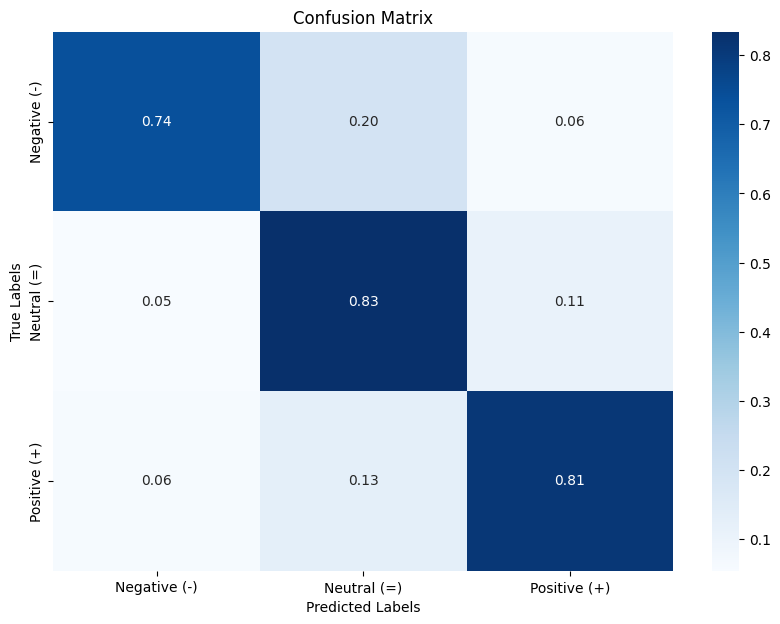

In [28]:
ENCODE = {"-": 0, "=": 1, "+": 2}
DECODE = {0: "-", 1: "=", 2: "+"}

def get_train_test(emb_df):
    X = emb_df[[f'emb_{i}' for i in range(768)]].values
    y = emb_df.labels.apply(lambda lab: ENCODE[lab]).values

    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    return X_train_resampled, X_val, X_test, y_train_resampled, y_val, y_test

def get_model(input_dim):
    model = Sequential([
        Input((input_dim,)),
        Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),  # Initial learning rate
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def get_scores(emb_df):
    X_train, X_val, X_test, y_train, y_val, y_test = get_train_test(emb_df)

    mlp = get_model(input_dim=768)
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    )
    lr_reduction = ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
    )

    history = mlp.fit(
        x=X_train,
        y=y_train,
        validation_data=(X_val, y_val),
        epochs=60,
        batch_size=32,
        callbacks=[early_stopping, lr_reduction],
        verbose=2
    )

    y_pred = mlp.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y_test, y_pred_labels)
    print(f"\nTest Accuracy: {accuracy:.4f}")

    report = classification_report(y_test, y_pred_labels, target_names=["Negative (-)", "Neutral (=)", "Positive (+)"])
    print("\nClassification Report:\n", report)

    cm = confusion_matrix(y_test, y_pred_labels, normalize='true')

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=["Negative (-)", "Neutral (=)", "Positive (+)"],
                yticklabels=["Negative (-)", "Neutral (=)", "Positive (+)"])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return history

history = get_scores(df_with_embeddings)

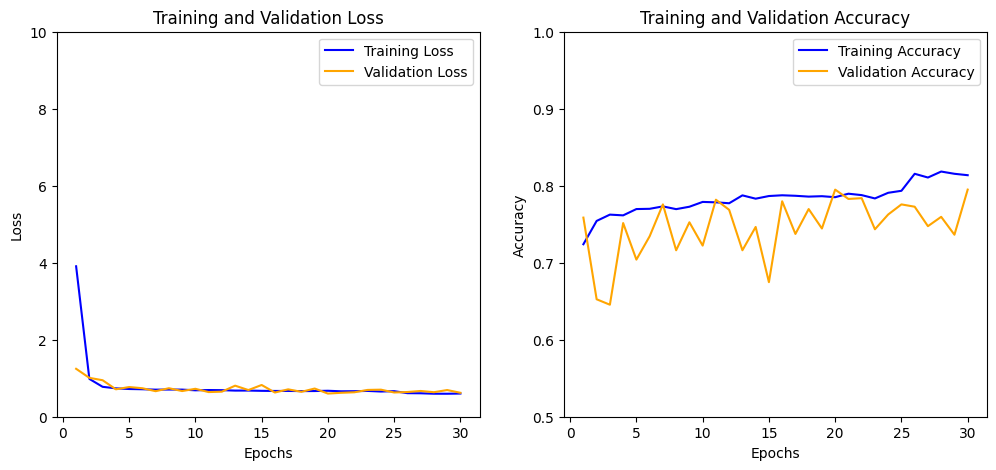

In [29]:
plot_learning_curves(history)